In [4]:
# Real life data

import logging
import threading
import json
import itertools
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import ibm_db
import shap

from pandas_profiling import ProfileReport
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions.db import Database
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.enginelog import EngineLogging
from iotfunctions.dbtables import FileModelStore
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from iotfunctions.dbtables import FileModelStore, DBModelStore
from mmfunctions.anomaly import (ARIMAForecaster, RobustThreshold)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import MinCovDet
from sklearn import metrics
import scipy as sp
import scipy.fftpack
import skimage as ski  
from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [5]:
db_schema=None
class DatabaseDummy:
    tenant_id = '###_IBM_###'
    db_type = 'db2'
    model_store = FileModelStore('./')
    def _init(self):
        return

db = DatabaseDummy()
        
print (db.tenant_id)

2021-04-20T16:20:33.045 INFO iotfunctions.dbtables.__init__ Init FileModelStore with path: ./
###_IBM_###


In [6]:
# Now we proceed to customer data - GOOD CASE

# Get stuff in
df_input_raw = pd.read_csv('./BP_DATA/IoTData.csv', index_col=False, parse_dates=['DATETIME'])

df_input_raw.rename(columns={'DATETIME':'timestamp'}, inplace=True)


df_input_raw['entity'] = 'demand'
#df_input_raw['entity']=df_input_raw['DEVICE_ID']
#df_input_raw['timestamp']=df_input_raw['RCV_TIMESTAMP_UTC']

# and sort it by timestamp
df_input_raw = df_input_raw.sort_values(by='timestamp')
df_input_raw = df_input_raw.set_index(['entity','timestamp']).dropna()

df_input_raw.describe()


,UMIDADE_REL,KW,KW2
count,8336.000000,8336.000000,8336.000000
mean,67.781550,587.668072,58.766807
std,16.769073,154.291984,15.429198
min,15.000000,8.400000,0.840000
25%,57.000000,470.400000,47.040000
50%,73.000000,557.760010,55.776001
75%,81.000000,703.919983,70.391998
max,92.000000,944.160000,94.416000


In [7]:
# df_input[['accel_power_0','accel_anomaly']].head(20)

# removed 'rms'
#features=['accel_speed','accel_power_0','accel_power_1','accel_power_2','accel_power_3','accel_power_4'] 
features=['KW']
targets=['KW']
predictions=['KW_pred']

df_input = df_input_raw

In [8]:
# train with the first 6000 observations
df_cut = df_input #[0:6000]

# Run Monitoring's anomaly detector functions
EngineLogging.configure_console_logging(logging.DEBUG)


robii = RobustThreshold(input_item='KW', threshold=0.95, output_item='KW_bool')

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = robii._build_entity_type(columns = [Column('KW',Float())], **jobsettings)
robii._entity_type = et
robii.auto_train = True
robii.delete_model = True

# allow training and delete existing models
df_cut = robii.execute(df=df_cut)

2021-04-20T16:20:35.402 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2021-04-20T16:20:35.405 DEBUG root.__init__ __init__SupervisedLearningTransformer
2021-04-20T16:20:35.407 DEBUG root.__init__ __init__ done with parameters: KW.KW_bool
RobustTransform KW 0.95 KW_bool
2021-04-20T16:20:35.413 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.3.1
2021-04-20T16:20:35.414 DEBUG iotfunctions.util.__init__ Starting trace
2021-04-20T16:20:35.416 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_RobustThreshold_20210420142035
2021-04-20T16:20:35.417 DEBUG iotfunctions.util.__init__ auto_save None
2021-04-20T16:20:35.418 DEBUG iotfunctions.util.categorize_args categorizing arguments
2021-04-20T16:20:35.419 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2021-04-20T16:

In [9]:
df_cut['KW_bool'].value_counts()

True     8116
False     220
Name: KW_bool, dtype: int64

In [11]:
robii.Max['demand']

887.04

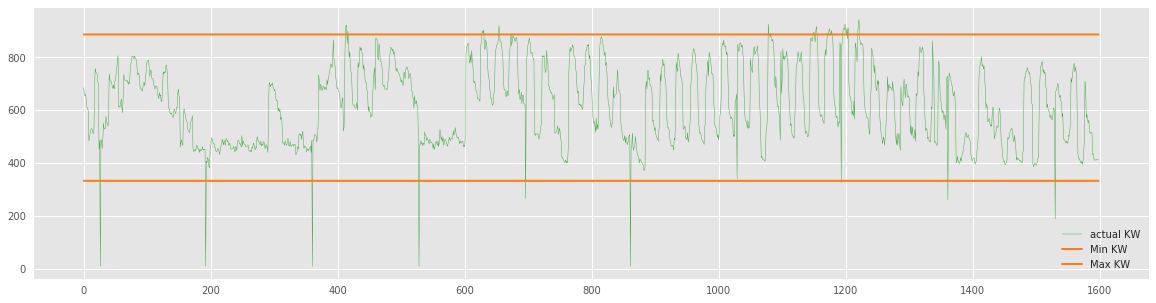

In [29]:
X = df_cut['KW'][1:1600].values
with plt.style.context(("seaborn", "ggplot")):
    plt.figure(figsize=(20,5))
    plt.plot(np.arange(0, X.shape[0], 1), X, c="tab:green", lw=0.4, label='actual KW')
    plt.plot(np.arange(0,X.shape[0],1), np.ones(X.shape[0]) *  robii.Min['demand'], c="tab:orange",
             lw=2, label='Min KW')
    plt.plot(np.arange(0,X.shape[0],1), np.ones(X.shape[0]) *  robii.Max['demand'], c="tab:orange",
             lw=2, label='Max KW')
    plt.legend(loc="best")

In [30]:

# train with the first 6000 observations
df_cut = df_input[0:6000]

# Run Monitoring's anomaly detector functions
EngineLogging.configure_console_logging(logging.DEBUG)


arimaii = ARIMAForecaster(input_item='KW',n_forecast=120,
                     output_item='KW_pred')

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = arimaii._build_entity_type(columns = [Column('KW',Float())], **jobsettings)
arimaii._entity_type = et

# allow training and delete existing models
df_cut = arimaii.execute(df=df_cut)

2021-04-20T16:28:39.378 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2021-04-20T16:28:39.380 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.3.1
2021-04-20T16:28:39.380 DEBUG iotfunctions.util.__init__ Starting trace
2021-04-20T16:28:39.381 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_ARIMAForecaster_20210420142839
2021-04-20T16:28:39.382 DEBUG iotfunctions.util.__init__ auto_save None
2021-04-20T16:28:39.383 DEBUG iotfunctions.util.categorize_args categorizing arguments
2021-04-20T16:28:39.383 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2021-04-20T16:28:39.384 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_ARIMAFORECASTER
Functions:
Granularities:
No schedules metadata
2021-04-20T16:28:39.385 DEBUG mm

2021-04-20T16:28:41.000 DEBUG matplotlib.font_manager._findfont_cached findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0.
2021-04-20T16:28:41.001 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
2021-04-20T16:28:41.002 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05
2021-04-20T16:28:41.002 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
2021-04-20T16:28:41.003 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05
2021-04-20T16:28:41.003 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal

2021-04-20T16:28:41.023 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter.ttf) normal normal 400 normal>) = 10.05
2021-04-20T16:28:41.024 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'KacstDecorative' (KacstDecorative.ttf) normal normal 400 normal>) = 10.05
2021-04-20T16:28:41.024 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Yrsa' (Yrsa-Regular.ttf) normal normal 400 normal>) = 10.05
2021-04-20T16:28:41.025 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Liberation Sans' (LiberationSans-BoldItalic.ttf) italic normal bold normal>) = 5.335
2021-04-20T16:28:41.025 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Pagul' (Pagul.ttf) normal normal 400 normal>) = 10.05
2021-04-20T16:28:41.026 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Loma' (Loma-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2021-04-20T16:28:41.026

2021-04-20T16:28:41.050 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Waree' (Waree-Oblique.ttf) oblique normal 400 normal>) = 11.05
2021-04-20T16:28:41.050 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'KacstPoster' (KacstPoster.ttf) normal normal 400 normal>) = 10.05
2021-04-20T16:28:41.051 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter-Oblique.ttf) oblique normal 400 normal>) = 11.05
2021-04-20T16:28:41.051 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Meera' (Meera-Regular.ttf) normal normal regular normal>) = 10.05
2021-04-20T16:28:41.051 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Norasi' (Norasi-Oblique.ttf) oblique normal 400 normal>) = 11.05
2021-04-20T16:28:41.052 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_WinIE6' (MathJax_WinIE6-Regular.otf) normal normal regular normal>) = 10.05
2021-04-20

2021-04-20T16:28:41.069 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Yrsa' (Yrsa-Medium.ttf) normal normal medium normal>) = 10.145
2021-04-20T16:28:41.069 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Mono' (TlwgMono-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2021-04-20T16:28:41.070 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'FontAwesome' (FontAwesome.otf) normal normal 400 normal>) = 10.05
2021-04-20T16:28:41.071 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_SansSerif' (MathJax_SansSerif-Italic.otf) italic normal 400 normal>) = 11.05
2021-04-20T16:28:41.071 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'FreeMono' (FreeMonoBold.ttf) normal normal bold normal>) = 10.335
2021-04-20T16:28:41.071 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_Typewriter' (MathJax_Typewriter-Regular.otf) normal normal regular norma

2021-04-20T16:28:41.084 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Norasi' (Norasi-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2021-04-20T16:28:41.085 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_Caligraphic' (MathJax_Caligraphic-Bold.otf) normal normal bold normal>) = 10.335
2021-04-20T16:28:41.085 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'KacstDigital' (KacstDigital.ttf) normal normal 400 normal>) = 10.05
2021-04-20T16:28:41.085 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Regular.ttf) normal normal 400 condensed>) = 10.25
2021-04-20T16:28:41.086 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Abyssinica SIL' (AbyssinicaSIL-R.ttf) normal normal 400 normal>) = 10.05
2021-04-20T16:28:41.086 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_Math' (MathJax_Math-Regular.ot

2021-04-20T16:28:41.104 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Mono' (TlwgMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
2021-04-20T16:28:41.105 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Laksaman' (Laksaman-Bold.ttf) normal normal bold normal>) = 10.335
2021-04-20T16:28:41.105 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'FreeSans' (FreeSansBold.ttf) normal normal bold normal>) = 10.335
2021-04-20T16:28:41.105 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'FreeSerif' (FreeSerifBold.ttf) normal normal bold normal>) = 10.335
2021-04-20T16:28:41.106 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Rasa' (Rasa-Bold.ttf) normal normal bold normal>) = 10.335
2021-04-20T16:28:41.106 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Typist' (TlwgTypist.ttf) normal normal 400 normal>) = 10.05
2021-04-20T16:28:41.106 DEBUG matplotlib.

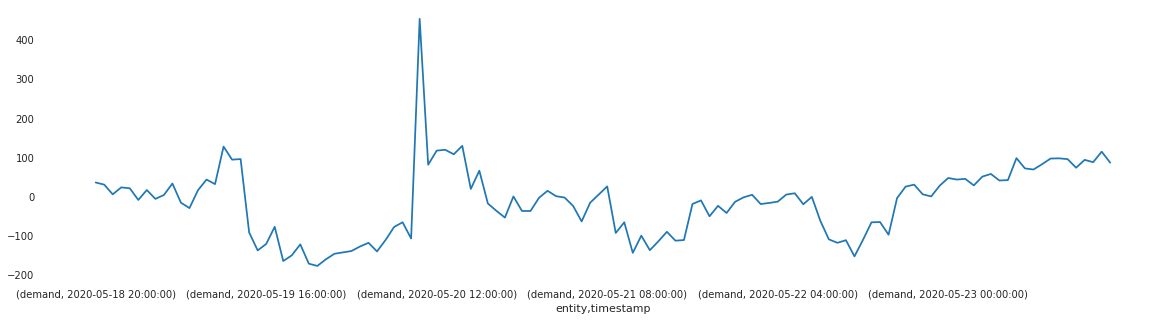

In [31]:
df_short = df_cut #[['KW', 'KW_pred']][5972:]
#df_short = df_cut[['KW']][5900:]
#df_short[['KW']][5900:6120].plot(figsize=(20,4))
#df_short[['KW_pred']][5800:].plot(figsize=(20,4))

diff = df_short['KW'][5880:6120] - df_short['KW_pred'][5760:]
diff.plot(figsize=(20,5))

In [32]:
arimaii

#print('RMSE111: ', sm.tools.eval_measures.rmse(forecast111[0:24], ndif[6000:6000 + 24]),
#      '\nRMSE200: ', sm.tools.eval_measures.rmse(forecast200[0:24], ndif[6000:6000 + 24]))

2021-04-19T19:55:06.913 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2021-04-19T19:55:06.916 DEBUG root.__init__ __init__SupervisedLearningTransformer
2021-04-19T19:55:06.918 DEBUG root.__init__ __init__ done with parameters: KW.KW_bool
RobustTransform KW -10 KW_bool
2021-04-19T19:55:06.921 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.3.1
2021-04-19T19:55:06.922 DEBUG iotfunctions.util.__init__ Starting trace
2021-04-19T19:55:06.924 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_RobustTransform_20210419175506
2021-04-19T19:55:06.925 DEBUG iotfunctions.util.__init__ auto_save None
2021-04-19T19:55:06.926 DEBUG iotfunctions.util.categorize_args categorizing arguments
2021-04-19T19:55:06.927 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2021-04-19T19:5

ValueError: Expected 2D array, got 1D array instead:
array=[690.48     685.44     656.88     ... 535.919983 517.440003 485.51999 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.